<h1 id="tocheading">1. CAPÍTULO III. Obtención de Datos derivados de la geodatabase</h1>
<div id="toc"></div> 

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
# Indicar Ubicación de la Carpeta de imágenes
# jupyter Notebook
url_img = r'C:\\Temp\\img\\'

from IPython.display import Image, display, Markdown

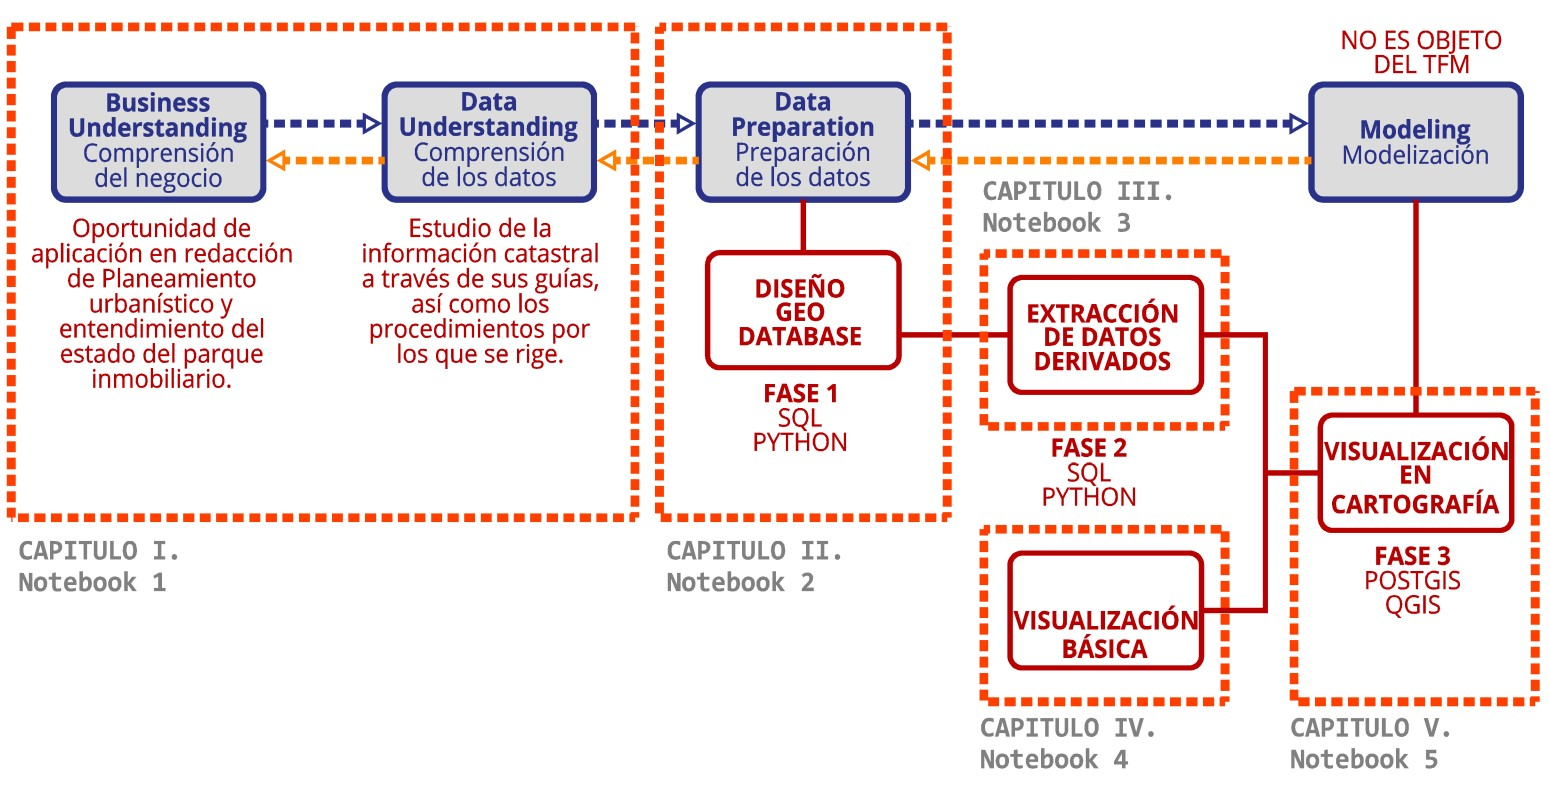

<p style="text-align: left;"><i>[Figura 1]. Esquema del TFM.</i></p>

In [13]:
# Nombre del archivo de imagen 00
nombre_archivo = "img_014.jpg"
texto = "[Figura 1]. Esquema del TFM."
anchura_porc = "80%"
# Ruta completa de la imagen
ruta_imagen = url_img + nombre_archivo

# Mostrar la imagen con un ancho del 60%
display(Image(filename=ruta_imagen, width=anchura_porc))

# Mostrar el texto centrado en cursiva debajo de la imagen
markdown_text = f'<p style="text-align: left;"><i>{texto}</i></p>'
display(Markdown(markdown_text))

En este notebook se muestra la potencia de la **geodatabase** diseñada para obtener **datos derivados** aplicables a la **redacción de planeamiento urbanístico**, así como el conocimiento del parque inmueble de la ciudad.<br>

A su vez, por cada query, se aporta una tabla con los **principales datos estadísticos**, para examinar tanto la distribución de las variables obtenidas como la ausencia de valores 'sin datos' en Catastro, así como posibles errores en la fuente de datos oficial.

Se han desarrollado un total de **13 tablas** a modo de ejemplo, destacando que la geodatabase permite extraer aún más información que la mostrada.

***Tablas Elaboradas.***:

|Tabla|Descripción|Fichero CSV
| :- | :------------- | :------------- |
|**`Tabla 01`**|Parámetros de Edificabilidad por Parcela.|t01_edificab_parcel.csv
|**`Tabla 02`**|Parámetros de Edificabilidad, antigüedad y uso por B.I.|t02_edificab_bi.csv
|**`Tabla 03`**|Parámetros de Edificabilidad, antigüedad y uso por B.I.|t03_numBI_uso_parcela.csv
|**`Tabla 04`**|Matriz de m2 de B.I. de distinto uso por cada parcerla.|t04_m2_BI_uso_parcela.csv
|**`Tabla 05`**|Matriz de número de altas catastrales por año y por uso.|t05_year_alta_usoBI.csv
|**`Tabla 06`**|Matriz de número de reformas por tipo y por año para B.I.|t06_num_tiporef_year_BI.csv
|**`Tabla 07`**|Matriz de Año de Reforma y Tipo de Reforma por Parcela Catastral.|t07_year_tiporef_Parcela.csv
|**`Tabla 08`**|Diferencia entre Antigüedad Real y Efectiva por B.I. Uso (V).|t08_dif_real_efect_BI.csv
|**`Tabla 09`**|Diferencia entre Antigüedad Real y Efectiva por Parcela Uso (V).|t09_dif_real_efect_parcel.csv
|**`Tabla 10`**|Parcelas sin edificaciones. Potenciales solares.|t10_potencial_solar.csv
|**`Tabla 11`**|Tipología Preponderante por Parcela.|t11_tipologías.csv
|**`Tabla 12`**|Bienes Inmuebles con un uso determinado. (ej.Turismo, Ocio y Hostelería).|t12_lista_Bi_uso.csv
|**`Tabla 13`**|Matriz del número de B.I. datados por año y por uso.|t13_numBI_uso_por_year

# 2. Instalación e importación de paquetes

In [12]:
# !pip install --upgrade tables
# !pip install --upgrade plotly

In [2]:
# Declare inline graphics
%matplotlib inline

In [3]:
# Celda de preparación -- Python 2 a 3
from __future__ import print_function, division

In [4]:
import sys
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns

import warnings
import psycopg2
from sqlalchemy import create_engine
import datetime

In [5]:
# Initialize the plotting space
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 16, 6;
plt.rcParams['figure.facecolor'] = 'white';

In [6]:
# Evitar la aparición de warnings
# Ignorar una advertencia específica por su categoría
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 3. Conexión a Base de Datos

---
***Variables a completar por usuario***:

<div class="alert alert-info"> 
    
+ **`ruta_tablas`** : Ruta donde se van a ubicar las tablas generadas para los Data Scientst.

+ **`municipio`** : Nombre que se asigna al esquema donde se alojan las tablas de la geodatabase.

+ **`tabla_geom`** : Nombre que se asigna a la tabla de PostgreSQL donde están los datos geo.

+ **`current_year`** : Año actual.
</div>
---

In [7]:
# Definición de las rutas y nombres de archivos
ruta_tablas = r'c:\\Temp\\tablas\\'
municipio = 'cordoba'
tabla_geom = 'parcel' 
# Automática
current_year=datetime.datetime.now().year

---
***Parámetros de Conexión a definir por el usuario***:

<div class="alert alert-info">
    
En su caso, deben declararse las siguientes variables en la siguiente celda:

+ **`host`** :
Dirección o nombre del servidor de la base de datos PostgreSQL.
+ **`database`** :
Nombre de la base de datos a la que se desea conectar.
+ **`user`** :
Nombre de usuario para la autenticación.
+ **`password`** :
Contraseña para la autenticación.
</div>
---

In [8]:
# Parámetros de conexión
host = "localhost"
database = "cat" # database a la que conectarse
user = "postgres" #owner
password = "postgres"

# Conexión
try:
    # Conexión a la base de datos PostgreSQL
    conexion = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )

    # Crear un cursor
    cursor = conexion.cursor()
    
    print("Conexión exitosa a la base de datos:", database)

except (Exception, psycopg2.Error) as error:
    print(f"Error al conectar a la base de datos:{database}", error)

Conexión exitosa a la base de datos: cat


Se ejecuta una consulta SQL para obtener valores únicos de la columna `coduso_428` de la tabla `t15`.<br> 
Posteriormente se mapean estos valores a textos específicos, para ser usados en consultas posteriores.<br>

In [9]:
# Ejecuta la consulta SQL para obtener los valores únicos de coduso_428
cursor.execute(f"SELECT DISTINCT coduso_428 FROM {municipio}.t15 ORDER BY coduso_428")

# Obtiene los resultados como una lista de tuplas
resultados = cursor.fetchall()

# Crea un diccionario de mapeo de valores a textos
mapeo = {
    'A': 'A_Almacén_Estacionamiento bigint',
    'B': 'B_Almacén agrario bigint',
    'C': 'C_Comercial bigint',
    'E': 'E_Cultural bigint',
    'G': 'G_Turismo_Ocio_Hostelería bigint',
    'I': 'I_Industrial bigint',
    'J': 'J_Industrial_Agrario bigint',
    'K': 'K_Deportivo bigint',
    'M': 'M_Urb_Jardin_NoEdificad bigint',
    'O': 'O_oficinas bigint',
    'P': 'P_EdifSingular bigint',
    'R': 'R_Religioso bigint',
    'T': 'T_Espectaculos bigint',
    'V': 'V_Residencial bigint',
    'Y': 'Y_Sanidad_Benefic bigint',
    'Z': 'Z_Agrario bigint',
    '0': '0_nodata bigint',
    '1': '1_Energ bigint',
    '2': '2_Presas_Embalses bigint',
    '3': '3_Carreteras bigint',
    '4': '4_Aerop_Puertos bigint',
    None: 'Sin_dato1 bigint'  # Añadir mapeo para None
}

# Caracter para manejar valores desconocidos
caracter_desconocido = 'X'

# Función para generar valores de texto incrementalmente
def generar_texto_desconocido(n):
    return f'Sin_dato({n}) bigint'

# Iterar sobre los resultados y construir la cadena formateada
texto_formateado = []
contador_desconocidos = 1

for valor in resultados:
    texto_mapeado = mapeo.get(valor[0])
    if texto_mapeado is None:
        # Utilizar el caracter desconocido y generar el texto
        texto_mapeado = generar_texto_desconocido(contador_desconocidos)
        contador_desconocidos += 1
    texto_formateado.append(texto_mapeado)

# Convierte la lista en una cadena de texto formateada
sql_script = ", ".join(texto_formateado)

# 4. Obtención de tablas para Data Scientist

## 4.1. Tabla 01- Parámetros de Edificabilidad por Parcela.

In [25]:
# DF_01 PARÁMETROS DE EDIFICABILIDAD POR PARCELA.

# Define la consulta SQL
sql = f'''
WITH supconst1 AS (
  SELECT pc_31, SUM(stl_84) AS suma1
  FROM {municipio}.t14
  WHERE NOT (cd_71 IN ('YOU', 'YJD', 'KDP', 'KPS')
  OR (pt_65 LIKE '-%' AND (cd_71 LIKE 'A%' OR cd_71 LIKE 'À%' OR cd_71 LIKE 'B%')))
  GROUP BY pc_31
),
sup_viv_query AS (
  SELECT pc_31, SUM(stl_84) AS sup_viv
  FROM {municipio}.t14
  WHERE cd_71 LIKE 'V%' OR cd_71 LIKE 'W%'
  GROUP BY pc_31
)
SELECT
  supconst1.pc_31,
  supconst1.suma1 AS sup_construida,
  t11.sup_296 AS sup_parcela,
  ROUND(supconst1.suma1 / t11.sup_296, 4) AS ind_edificab,
  COALESCE(sup_viv_query.sup_viv, 0) AS sup_viv,
  ROUND(COALESCE(sup_viv_query.sup_viv, 0) / NULLIF(supconst1.suma1, 0) * 100, 2) AS porc_uso_viv
FROM supconst1
JOIN {municipio}.t11 ON supconst1.pc_31 = {municipio}.t11.pc_31
LEFT JOIN sup_viv_query ON supconst1.pc_31 = sup_viv_query.pc_31
ORDER BY ind_edificab DESC;

'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\2345037525.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,pc_31,sup_construida,sup_parcela,ind_edificab,sup_viv,porc_uso_viv
0,4956602UG4945N,1285.0,55,23.3636,1285.0,100.00
1,3863701UG4936S,3793.0,232,16.3491,832.0,21.94
2,3647616UG4934N,730.0,64,11.4063,658.0,90.14
3,3349201UG4934N,8563.0,842,10.1698,0.0,0.00
4,3647621UG4934N,1166.0,115,10.1391,909.0,77.96


**Tabla 01. Parámetros de Edificabilidad por Parcela:**

|columna|descripción
| :- | :------------- |
|**`sup_construida`**|superficie construida por cada parcela
|**`sup_parcela`**|superficie de la parcela
|**`ind_edificab`**|Indice de edificabilidad = sup_construida/sup_parcela
|**`sup_viv`**|superficie construida de uso vivienda
|**`porc_uso_viv`**|porcentaje de superficie de uso vivienda sobre el total de la superficie construida

In [26]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't01_edificab_parcel.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_01 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [27]:
# Obtener estadísticas generales del DataFrame df_01
estadísticas_1 = df_01.describe()

# Redondear los valores a dos decimales
estadísticas_1 = estadísticas_1.round(2)

# Redondear ind_edificab a cuatro decimales
estadísticas_1['ind_edificab'] = estadísticas_1['ind_edificab'].round(4)

# Mostrar las estadísticas redondeadas
estadísticas_1

,sup_construida,sup_parcela,ind_edificab,sup_viv,porc_uso_viv
count,36986.00,36986.00,36986.00,36986.00,36986.00
mean,790.98,7460.88,1.38,456.88,75.51
std,3456.20,93642.30,1.44,1244.84,31.92
min,1.00,5.00,0.00,0.00,0.00
25%,136.00,120.00,0.29,85.00,67.46
50%,234.00,305.00,0.91,157.00,87.85
75%,568.00,1335.00,1.90,324.00,100.00
max,309262.00,5019839.00,23.36,40865.00,100.00


## 4.2. Tabla 02. Parámetros de Edificabilidad, antigüedad y uso por B.I.

In [28]:
# PARAMETROS DE LOS BIENES INMUEBLES

# Define la consulta SQL
sql = f'''
WITH supconstruida AS (
    SELECT 
        pc_31,
        nobf_51 AS car_45,
        SUM(stl_84) AS sup_construida
    FROM {municipio}.t14
    WHERE NOT (cd_71 IN ('YOU', 'YJD', 'KDP', 'KPS') 
               OR (pt_65 LIKE '-%' AND (cd_71 LIKE 'A%' OR cd_71 LIKE 'À%' OR cd_71 LIKE 'B%')))
    GROUP BY pc_31, nobf_51
),
supconstnocomput AS (
    SELECT 
        pc_31,
        nobf_51 AS car_45,
        SUM(stl_84) AS sup_const_no_comput
    FROM {municipio}.t14
    WHERE pt_65 LIKE '-%' AND (cd_71 LIKE 'A%' OR cd_71 LIKE 'À%' OR cd_71 LIKE 'B%')
    GROUP BY pc_31, nobf_51
)

SELECT 
    t15.tipo_29 AS tipo,
    CONCAT(t15.pc_31, t15.car_45) AS ref_cat_bi,
    t15.coduso_428 AS uso,
    t15_428.USO15428 AS uso_bi,
    ({current_year} - t15.ant_372) AS antiguedad,
    sc.sup_construida,
    scnc.sup_const_no_comput,
    ROUND(t15.cpt_462 / 1000000, 2) AS porc_propiedad
FROM {municipio}.t15 t15
JOIN cod.t15_428 ON t15.coduso_428 = t15_428.coduso_428
LEFT JOIN supconstruida sc ON t15.pc_31 = sc.pc_31 AND t15.car_45 = sc.car_45
LEFT JOIN supconstnocomput scnc ON t15.pc_31 = scnc.pc_31 AND t15.car_45 = scnc.car_45;
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3645424948.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,tipo,ref_cat_bi,uso,uso_bi,antiguedad,sup_construida,sup_const_no_comput,porc_propiedad
0,UR,3727504UG4932N0007,V,Residencial,62.0,53.0,NaN,0.0
1,UR,3727504UG4932N0010,V,Residencial,62.0,53.0,NaN,0.0
2,UR,3727504UG4932N0020,V,Residencial,62.0,53.0,NaN,0.0
3,UR,3826306UG4932N0002,C,Comercial,63.0,15.0,NaN,0.0
4,UR,3826306UG4932N0004,V,Residencial,63.0,61.0,NaN,0.0


**Tabla 02. Parámetros de Edificabilidad, antigüedad y uso por B.I.**

|columna|descripción
| :- | :------------- |
|**`tipo`**|Clase del Bien inmueble (UR, RU, BI)
|**`ref_cat_bi`**|Código de referencia del Bien Inmueble
|**`uso`**|Código de uso del Bien Inmueble
|**`uso_bi`**|Uso del Bien Inmueble
|**`antiguedad`**|Antigüedad del bien inmueble
|**`sup_construida`**|m²t sobre rasante y bajo rasante (salvo para uso aparcamiento y almacenamiento).
|**`sup_const_no_comput`**|m²t bajo rasante de uso aparcamiento y almacenamiento
|**`porc_propiedad`**|% de propiedad

In [29]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't02_edificab_bi.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_02 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [30]:
# Obtener estadísticas generales del DataFrame df_02
# Filtrar los datos para cuando tipo=='UR'
df_ur = df_02[df_02['tipo'] == 'UR']

# Filtrar los datos para cuando tipo=='RU'
df_ru = df_02[df_02['tipo'] == 'RU']

# Obtener estadísticas generales para UR
estadisticas_ur = df_ur.describe().round(2)

# Obtener estadísticas generales para RU
estadisticas_ru = df_ru.describe().round(2)

# Mostrar las estadísticas para UR
print("Estadísticas para tipo 'UR':")
print(estadisticas_ur)

# Mostrar las estadísticas para RU
print("\nEstadísticas para tipo 'RU':")
print(estadisticas_ru)

Estadísticas para tipo 'UR':
       antiguedad  sup_construida  sup_const_no_comput  porc_propiedad
count   252215.00       186835.00             83218.00       256048.00
mean        37.78          147.59                26.89           14.49
std         20.46         1251.47               393.93           33.40
min          0.00            0.00                 1.00            0.00
25%         23.00           68.00                11.00            0.00
50%         40.00           88.00                15.00            0.00
75%         51.00          117.00                22.00            3.00
max       2022.00       309262.00             70038.00          100.00

Estadísticas para tipo 'RU':
       antiguedad  sup_construida  sup_const_no_comput  porc_propiedad
count      490.00          480.00                  0.0         4874.00
mean        51.07         1017.81                  NaN           47.68
std         20.49         7486.18                  NaN           47.89
min          8.00 

## 4.3. Tabla 03. Matriz de número de B.I. de distinto uso por cada parcerla.

In [31]:
# Matriz de número de B.I. de distinto uso por cada parcerla
sql = f'''
--METODO CROSSTABLE
--numero de BI con distinto uso por parcela
select *
from crosstab(
    --A/ CAMPOS_A_OBTENER
    'select pc_31 as ref_cat_parcela, coduso_428, count(coduso_428) as num_bi
     from {municipio}.t15
     group by pc_31, coduso_428 
     order by pc_31, coduso_428 desc',
    
    --B/ ESTRUCTURA_DE_LOS _CAMPOS
    'select distinct coduso_428 
     from {municipio}.t15
     order by coduso_428'
) as
(
    ref_cat_parcela character varying(14),
    {sql_script}
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3137876280.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,ref_cat_parcela,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
0,000040100UG38F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,000040200UG38F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,0000658000001S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,0000663000001S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,000070100UG59H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


**Tabla 03. Matriz de número de B.I. de distinto uso por cada parcerla.**

|columna|descripción
| :- | :------------- |
|**`ref_cat_parcela`**|Referencia Catastral de la Parcela
|**`varios campos`**|Número de B.I. por cada uso en cada parcela.

In [32]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't03_numBI_uso_parcela.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_03 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [33]:
# Obtener estadísticas generales del DataFrame df_03
estadísticas_3 = df_03.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_3 = estadísticas_3.applymap(formatear_numero)

estadísticas_3

,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
count,2947,4511,401,386,2745,245,4029,894,55,124,9,32692,278,2386
mean,24.32,3.36,1.15,1.44,1.79,1.01,1.13,3.28,1.02,1.06,1,4.74,1.31,2.04
std,52.61,5.52,1.49,3.11,4.82,0.11,2.22,8.11,0.13,0.31,0,12.60,1.08,9.45
min,1,1,1,1,1,1,1,1,1,1,1,1,1,1
25%,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50%,9,2,1,1,1,1,1,1,1,1,1,1,1,1
75%,25,4,1,1,1,1,1,2,1,1,1,2,1,1
max,1228,170,30,56,117,2,96,122,2,3,1,386,11,275


## 4.4. Tabla 04. Matriz de m2 de B.I. de distinto uso por cada parcerla.

In [34]:
# Matriz de m2 de B.I. de distinto uso por cada parcerla
sql = f'''
--METODO CROSSTABLE
--m2 por uso de BI por parcela catastral
select *
from crosstab(
    --A/ CAMPOS_A_OBTENER
    'select pc_31 as ref_cat_parcela, coduso_428, sum(sfc_442) as m2_bi
     from {municipio}.t15
     group by pc_31, coduso_428 
     order by pc_31, coduso_428 desc',
    
    --B/ ESTRUCTURA_DE_LOS _CAMPOS
    'select distinct coduso_428 
     from {municipio}.t15
     order by coduso_428'
) as
(
    ref_cat_parcela character varying(14),
    {sql_script}
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\1498301165.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,ref_cat_parcela,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
0,000040100UG38F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN
1,000040200UG38F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,NaN
2,0000658000001S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.0,NaN,NaN
3,0000663000001S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,NaN
4,000070100UG59H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667.0,NaN,NaN


**Tabla 04. Matriz de m2 de B.I. de distinto uso por cada parcerla.**

|columna|descripción
| :- | :------------- |
|**`ref_cat_parcela`**|Referencia Catastral de la Parcela
|**`varios campos`**|m2 de B.I. por cada uso en cada parcela

In [35]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't04_m2_BI_uso_parcela.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_04 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [36]:
# Obtener estadísticas generales del DataFrame df_04
estadísticas_4 = df_04.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_4 = estadísticas_4.applymap(formatear_numero)

estadísticas_4

,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
count,2947,4511,401,386,2745,245,4029,894,55,124,9,32692,278,2386
mean,787.08,459.17,3312.05,1182.99,1678.23,4093.87,36.59,1195.72,8220.45,1579.72,5617.56,600.02,1396.83,204.69
std,2224.23,2934.41,10351.03,2378.52,8045.44,18414.13,797.02,4213.34,19269.12,2578.31,10115.95,1519.12,4782.54,3379.74
min,2,7,24,28,0,13,0,13,11,66,79,9,17,0
25%,101,97,188,245.25,172,61,0,100.25,1020,359.25,903,140,95.25,0
50%,299,193,1066,429.50,424,256,0,269.50,2558,749.50,1400,244,203,0
75%,738.50,348,3752,940.75,1077,2157,0,833,6080,1743.50,5469,489,799.75,0
max,70845,141342,191982,20842,309262,268629,34010,82830,129389,20396,31778,46348,44034,161417


## 4.5. Tabla 05. Matriz de número de altas catastrales  por año y por uso.



In [37]:
# Matriz de número de altas por año y por uso
sql = f'''
--METODO CROSSTABLE
--numero de BI con distinto uso por parcela
select *
from crosstab(
    --A/ CAMPOS_A_OBTENER
    'SELECT 
        CASE 
          WHEN t15.ant_372 > {current_year} OR t15.ant_372 <= 0 THEN NULL
          ELSE t15.ant_372
        END AS year_alta,
        coduso_428,  
        COUNT(t15.coduso_428) AS num_BI
     FROM {municipio}.t15
     GROUP BY ant_372, coduso_428
     ORDER BY ant_372 DESC',
    
    --B/ ESTRUCTURA_DE_LOS _CAMPOS
    'select distinct coduso_428 
     from {municipio}.t15
     order by coduso_428'
) as
(
    year_alta bigint,
    {sql_script}
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3416869618.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,year_alta,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
0,NaN,2.0,NaN,NaN,10.0,3.0,3.0,3785.0,2.0,NaN,NaN,1.0,25.0,2.0,4384.0
1,2023.0,126.0,2.0,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,250.0,NaN,NaN
2,2022.0,866.0,10.0,NaN,5.0,2.0,NaN,72.0,NaN,NaN,NaN,NaN,1027.0,NaN,NaN
3,2021.0,673.0,12.0,1.0,11.0,1.0,NaN,14.0,2.0,NaN,NaN,NaN,809.0,NaN,NaN
4,2020.0,1064.0,3.0,1.0,4.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1165.0,NaN,NaN


**Tabla 05. Matriz de número de altas catastrales por año y por uso.**

|columna|descripción
| :- | :------------- |
|**`yar_alta`**|Año.
|**`varios campos`**|Número de altas catastrales de B.I. por cada uso.

In [38]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't05_year_alta_usoBI.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_05 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [39]:
# Obtener estadísticas generales del DataFrame df_05
estadísticas_5 = df_05.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_5 = estadísticas_5.applymap(formatear_numero)

estadísticas_5

,year_alta,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
count,134,92,104,80,84,100,57,68,87,37,53,9,131,68,62
mean,1870.96,779,145.88,5.79,6.61,49.16,4.35,66.99,33.67,1.51,2.49,1,1183.07,5.37,78.60
std,371.17,821.25,177.34,6.33,8.30,57.10,4.02,458.02,47.42,1.10,3.29,0,1463.34,4.55,556.01
min,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
25%,1923.25,8,9,2,2.75,4,2,1,3.50,1,1,1,26,2,2
50%,1956.50,496,63.50,4,4,19,3,3,17,1,2,1,567,4,3
75%,1989.75,1384.75,251,7,8,90.50,5,9.25,41,1,2,1,2039.50,8,4
max,2023,3371,929,40,61,273,24,3785,246,5,21,1,9039,25,4384


## 4.6. Tabla 06. Matriz de número de reformas por tipo y por año para B.I.

In [40]:
# Matriz de número de reformas por tipo y por año para B.I.
sql = f'''
SELECT *
FROM crosstab(
    -- Consulta principal
    'SELECT 
        CASE 
            WHEN t14.ar_75 = 0 OR t14.ar_75 > 2023 THEN NULL
            ELSE t14.ar_75
        END AS year_Reforma, 
        tr_74 AS CATEGORY,
        COUNT(DISTINCT(CONCAT(t15.pc_31, car_45))) AS VALUES
    FROM {municipio}.t15
    INNER JOIN {municipio}.t14
    ON CONCAT(t14.pc_31, nobf_51) = CONCAT(t15.pc_31, car_45)
    WHERE t15.coduso_428 LIKE ''V''
    GROUP BY year_Reforma, tr_74
    ORDER BY year_Reforma DESC',
    
    -- Consulta para obtener la estructura de los campos
    'SELECT DISTINCT tr_74 
    FROM {municipio}.t14
    ORDER BY tr_74 DESC'
) AS resultado(
    year_Reforma bigint,
    R_1_Integral bigint,
    O_2_Total bigint,
    I_4_Minima bigint,
    E_3_Media bigint,    
    Sin_Reforma bigint
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\1642050909.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,year_reforma,r_1_integral,o_2_total,i_4_minima,e_3_media,sin_reforma
0,NaN,NaN,NaN,NaN,NaN,149759.0
1,2023.0,NaN,24.0,31.0,5.0,NaN
2,2022.0,19.0,52.0,114.0,66.0,NaN
3,2021.0,5.0,76.0,138.0,29.0,NaN
4,2020.0,5.0,59.0,113.0,7.0,NaN


**Tabla 06. Matriz de número de reformas por tipo y por año para B.I.**

|columna|descripción
| :- | :------------- |
|**`year_reforma`**|Año donde se produce la reforma.
|**`r_1_integral`**|Reforma de tipo **INTEGRAL**.
|**`o_2_total`**|Reforma de tipo **TOTAL**.
|**`e_3_media`**|Reforma de tipo **MEDIA**.
|**`i_4_minima`**|Reforma de tipo **MÍNIMA**.
|**`sin_reforma`**|No se tiene constancia de que se haya producido una reforma en el B.I.

In [41]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't06_num_tiporef_year_BI.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_06 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [42]:
# Obtener estadísticas generales del DataFrame df_06
estadísticas_6 = df_06.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_6 = estadísticas_6.applymap(formatear_numero)

estadísticas_6

,year_reforma,r_1_integral,o_2_total,i_4_minima,e_3_media,sin_reforma
count,68,49,60,56,64,3
mean,1987.13,18.39,31.13,36.07,46.98,49922.67
std,24.63,16.82,26.39,40.38,57.99,86460.80
min,1900,1,1,1,1,1
25%,1972.75,5,3.75,8.75,5.75,4.50
50%,1989.50,14,29.50,24,29.50,8
75%,2006.25,28,52.25,38,68.75,74883.50
max,2023,67,88,170,321,149759


## 4.7. Tabla 07. Matriz de Año de Reforma y Tipo  por Parcela Catastral. Uso V.

In [43]:
# Matriz de Año de Reforma y Tipo de Reforma  por Parcela Catastral. Uso Residencial

sql = f'''
SELECT *
FROM crosstab(
    -- Consulta principal
    'SELECT 
        t14.pc_31 AS RefCat,
        avg(ant_372) AS Antig_BI,
        tr_74 AS TipoRef, 
        ar_75 AS año_ref        
    FROM {municipio}.parcel
    JOIN {municipio}.t14 ON {tabla_geom}.refcat = t14.pc_31
    JOIN {municipio}.t15 ON {tabla_geom}.refcat = t15.pc_31
    WHERE coduso_428 = ''V''
    GROUP BY t14.pc_31, tr_74, ar_75
    ORDER BY t14.pc_31',
    
    -- Consulta para obtener la estructura de los campos
    'SELECT DISTINCT tr_74 
    FROM {municipio}.t14
    ORDER BY tr_74'
) AS resultado(
    refcat character varying(14),
    Antig_BI double precision,
    Sin_Reforma bigint,
    E_Ref_Media bigint,
    I_Ref_Minima bigint,
    O_Ref_Total bigint,
    R_Ref_Integral bigint
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3140866928.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,refcat,antig_bi,sin_reforma,e_ref_media,i_ref_minima,o_ref_total,r_ref_integral
0,0009801UG3900N,1998.0,0.0,NaN,NaN,NaN,NaN
1,0009802UG3900N,1997.0,0.0,NaN,NaN,NaN,NaN
2,0009804UG3900N,1996.0,0.0,NaN,NaN,NaN,NaN
3,0009805UG3900N,1995.0,0.0,NaN,NaN,NaN,NaN
4,001000800UG39B,1983.0,0.0,NaN,NaN,NaN,NaN


**Tabla 07. Matriz de Año de Reforma y Tipo de Reforma  por Parcela Catastral. Uso V.**

|columna|descripción
| :- | :------------- |
|**`refcat`**|Referencia Catastral de Parcela (14 dígitos).
|**`antig_bi`**|Año de Antigüedad media de los Bienes Inmuebles de la Parcela.
|**`r_ref_integral`**|Año de reforma de tipo **INTEGRAL**.
|**`o_ref_total`**|Año de reforma de tipo **TOTAL**.
|**`e_ref_media`**|Año de reforma de tipo **MEDIO**.
|**`i_ref_minima`**|Año de reforma de tipo **MÍNIMA**.
|**`sin_reforma`**|No se tiene constancia de que se haya producido una reforma.

In [44]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't07_year_tiporef_Parcela.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_07 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [45]:
# Obtener estadísticas generales del DataFrame df_07
estadísticas_7 = df_07.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_7 = estadísticas_7.applymap(formatear_numero)

estadísticas_7

,antig_bi,sin_reforma,e_ref_media,i_ref_minima,o_ref_total,r_ref_integral
count,30655,28205,3229,877,2479,532
mean,1977.21,0.48,1999.44,1998.62,2006.29,1999.77
std,25.24,58.94,12.29,12.48,10.42,10.54
min,207,0,1900,1960,1950,1940
25%,1959,0,1990,1990,2000,1994
50%,1979,0,1999,1998,2008,2000
75%,1998,0,2008,2009,2014,2006
max,2023,9500,2023,2023,2023,2023


## 4.8. Tabla 08. Diferencia entre Antigüedad Real y Efectiva por B.I. Uso (V).

In [47]:
# Diferencia entre Antigüedad Real y Efectiva por B.I. Uso (V).
sql = f'''
SELECT 
    t15.pc_31 AS parcela,
    CONCAT(t15.pc_31, car_45) AS Bien_Inmueble,
    CASE WHEN MAX(t14.aec_79) <= 0 THEN NULL ELSE MAX(t14.aec_79) END AS year_Efectiva,
    CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL
         WHEN AVG(t15.ant_372) > {current_year} THEN NULL
         ELSE AVG(t15.ant_372) END AS year_Real,
    {current_year} - MAX(t14.aec_79) AS Antig_Efectiva,
    CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL
         WHEN AVG(t15.ant_372) > {current_year} THEN NULL
         ELSE {current_year} - AVG(t15.ant_372) END AS Antig_Real,
    MAX(t14.aec_79) - (CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL
                           WHEN AVG(t15.ant_372) > {current_year} THEN NULL
                           ELSE AVG(t15.ant_372) END) AS Diferencia
FROM cordoba.t15
INNER JOIN {municipio}.t14 ON CONCAT(t14.pc_31, nobf_51) = CONCAT(t15.pc_31, car_45)
WHERE t15.coduso_428 LIKE 'V'
GROUP BY t15.pc_31, CONCAT(t15.pc_31, car_45)
ORDER BY Diferencia DESC;
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\1610946282.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,parcela,bien_inmueble,year_efectiva,year_real,antig_efectiva,antig_real,diferencia
0,14900A01000016,14900A010000160001,1992.0,NaN,31.0,NaN,NaN
1,14900A03500048,14900A035000480001,1990.0,NaN,33.0,NaN,NaN
2,08990029221102,089900292211020001,NaN,1960.0,NaN,63.0,NaN
3,14900A04000013,14900A040000130001,1955.0,NaN,68.0,NaN,NaN
4,14900A03800028,14900A038000280001,1990.0,NaN,33.0,NaN,NaN


**Tabla 08. Diferencia entre Antigüedad Real y Efectiva por B.I. Uso (V).**

|columna|descripción
| :- | :------------- |
|**`parcela`**|Referencia Catastral de la Parcela del B.I.
|**`bien_inmueble`**|Referencia Catastral del Bien Inmueble.
|**`year_efectiva`**|Año de Antigüedad Efectiva. (Ponderizando por Reformas).
|**`year_real`**|Año de Antigüedad Real del B.I.
|**`antig_efectiva`**|Antigüedad Efectiva. (Ponderizando por Reformas).
|**`antig_real`**|Antigüedad Real del B.I.
|**`diferencia`**|Diferencia Antig. Real y Efectiva. (Indicador del grado de rehabilitación)

In [48]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't08_dif_real_efect_BI.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_08 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [49]:
# Obtener estadísticas generales del DataFrame df_08
estadísticas_8 = df_08.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_8 = estadísticas_8.applymap(formatear_numero)

estadísticas_8

,year_efectiva,year_real,antig_efectiva,antig_real,diferencia
count,154981,154957,154981,154957,154956
mean,1983.45,1981.92,39.55,41.08,1.53
std,19.51,20.86,19.51,20.86,8.79
min,200,190,0,0,-45
25%,1970,1970,25,26,0
50%,1981,1980,42,43,0
75%,1998,1997,53,53,0
max,2023,2023,1823,1833,1770


## 4.9. Tabla 09. Diferencia entre Antigüedad Real y Efectiva por Parcela Uso (V).

In [50]:
# Diferencia entre Antigüedad Real y Efectiva por Parcela Uso (V).
# menos filas al haber menos parcelas que en CAT
sql = f'''
SELECT 
    t15.pc_31 AS parcela,
    COUNT(CONCAT(t15.pc_31, car_45)) AS numero_BI_viv,
    CASE WHEN MAX(t14.aec_79) <= 0 THEN NULL
         WHEN MAX(t14.aec_79) > {current_year} THEN NULL
         ELSE MAX(t14.aec_79) END AS year_efectiva,
    CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL
         WHEN AVG(t15.ant_372) > {current_year} THEN NULL
         ELSE AVG(t15.ant_372) END AS year_Real,
    CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL 
         ELSE {current_year} - AVG(t15.ant_372) END AS antig_efectiva,
    CASE WHEN AVG(t15.ant_372) <= 0 THEN NULL
         WHEN AVG(t15.ant_372) > {current_year} THEN NULL
         ELSE {current_year} - AVG(t15.ant_372) END AS antig_real,
    CASE WHEN MAX(t14.aec_79) <= 0 THEN NULL
         ELSE MAX(t14.aec_79) - AVG(t15.ant_372) END AS diferencia
FROM {municipio}.t15
INNER JOIN {municipio}.t14 ON CONCAT(t14.pc_31, nobf_51) = CONCAT(t15.pc_31, car_45)
WHERE t15.coduso_428 LIKE 'V'
GROUP BY t15.pc_31
ORDER BY diferencia DESC;
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3857254403.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,parcela,numero_bi_viv,year_efectiva,year_real,antig_efectiva,antig_real,diferencia
0,14900A02400006,3,1980.0,NaN,NaN,NaN,NaN
1,1881108UG4918S,3,1994.0,NaN,NaN,NaN,NaN
2,1881107UG4918S,3,1994.0,NaN,NaN,NaN,NaN
3,1881103UG4918S,3,1994.0,NaN,NaN,NaN,NaN
4,14900A09800069,4,1990.0,NaN,NaN,NaN,NaN


**Tabla 09. Diferencia entre Antigüedad Real y Efectiva por Parcela Uso (V).**

|columna|descripción
| :- | :------------- |
|**`parcela`**|Referencia Catastral de la Parcela.
|**`numero_bi_viv`**|Número de B.I. de uso Residencial en la Parcela Catastral.
|**`year_efectiva`**|Año de Antigüedad Efectiva de los B.I. de la Parcela. (V)
|**`year_real`**|Año de Antigüedad Real de los B.I. de la Parcela.(V)
|**`antig_efectiva`**|Antigüedad Efectiva. (Ponderizando por Reformas).(V)
|**`antig_real`**|Antigüedad Real (V)
|**`diferencia`**|Diferencia Antig. Real y Efectiva. (Indicador del grado de rehabilitación)

In [51]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't09_dif_real_efect_parcel.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_09 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [52]:
# Obtener estadísticas generales del DataFrame df_09
estadísticas_9 = df_09.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_9 = estadísticas_9.applymap(formatear_numero)

estadísticas_9

,numero_bi_viv,year_efectiva,year_real,antig_efectiva,antig_real,diferencia
count,32692,32691,32668,32668,32668,32667
mean,8.04,1983.94,1977.71,45.29,45.29,6.23
std,22.37,23.64,27.67,27.67,27.67,17.54
min,1,207,190,0,0,-45
25%,2,1969,1959.69,24,24,0
50%,4,1989,1979,44,44,0
75%,7,2002,1999,63.31,63.31,2
max,949,2023,2023,1833,1833,1770


## 4.10. Tabla 10. Parcelas sin edificaciones. Potenciales solares.

In [53]:
# Parcelas sin edificaciones. Potenciales solares.

sql = f'''
select distinct t15.pc_31 as Ref_Catastral,
    coduso_428 as codigo_uso,
    t14.pc_31, 
    sfc_442 as valor_control, 
    sfs_452 as sup_BI
from {municipio}.t15
left join {municipio}.t14
    on t15.pc_31=t14.pc_31
where t14.pc_31 is NULL
    and coduso_428 like 'M%%'
order by sfs_452 desc;
'''
# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3571902291.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,ref_catastral,codigo_uso,pc_31,valor_control,sup_bi
0,14900A06900043,M,None,0,369509
1,14900A06900034,M,None,0,337128
2,14900A08600079,M,None,0,335822
3,14900A08600007,M,None,0,267214
4,14900A08600004,M,None,0,223591


**Tabla 10. Diferencia entre Antigüedad Real y Efectiva por Parcela Uso (V).**

|columna|descripción
| :- | :------------- |
|**`ref_catastral`**|Referencia Catastral de la Parcela.
|**`codigo_uso`**|Codificación Uso B.I. **(M)** Suelos sin edificar.
|**`valor_control`**|Superficie m2t. (Debe ser = 0)
|**`sup_bi`**|Correspondería con la superficie de parcela

In [54]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't10_potencial_solar.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_10 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [55]:
# Obtener estadísticas generales del DataFrame df_10
estadísticas_10 = df_10.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_10 = estadísticas_10.applymap(formatear_numero)

estadísticas_10

,pc_31,valor_control,sup_bi
count,0,3764,3764
mean,nan,0,3581.19
std,nan,0,15135.50
min,nan,0,0
25%,nan,0,485
50%,nan,0,1401
75%,nan,0,2592
max,nan,0,369509


## 4.11. Tabla 11. Tipología Preponderante por Parcela.

In [56]:
#  Tipología Preponderante por Parcela.
sql = f'''
SELECT DISTINCT ON (t14.pc_31) t14.pc_31 AS ref_cat,
    SUM(t14.stl_84) AS superf,
    COUNT(t14.pc_31) AS num_const,
    SUBSTRING(t14.tip_105, 1, 4) AS cod_tip,
    t14_105.uso1,
    t14_105.tipolog1,
    t14_105.tipolog2
FROM {municipio}.t14
JOIN cod.t14_105 ON t14_105.tip_105 = t14.tip_105
JOIN {municipio}.{tabla_geom} ON parcel.refcat = t14.pc_31
WHERE SUBSTRING(t14.tip_105, 1, 4) NOT LIKE '0113'
GROUP BY ref_cat, cod_tip, t14_105.uso1, t14_105.tipolog1, t14_105.tipolog2
ORDER BY ref_cat, superf DESC;
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3767068302.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,ref_cat,superf,num_const,cod_tip,uso1,tipolog1,tipolog2
0,000110100UG69H,10865.0,3,0213,INDUSTRIAL,NAVE FABRICACION - ALMACENAM,NAVE ALMACENAMIENTO
1,000900100UG39F,2455.0,7,0721,OCIO Y HOSTELERÍA,SIN RESIDENCIA,RESTAURANTES
2,0009801UG3900N,44.0,1,0121,RESIDENCIAL,UNIFAMILIAR,AISLADA O PAREADA
3,0009802UG3900N,339.0,3,0121,RESIDENCIAL,UNIFAMILIAR,AISLADA O PAREADA
4,0009804UG3900N,109.0,1,0121,RESIDENCIAL,UNIFAMILIAR,AISLADA O PAREADA


**Tabla 11. Tipología Preponderante por Parcela.**

|columna|descripción
| :- | :------------- |
|**`ref_cat`**|Referencia Catastral de la Parcela.
|**`superf`**|Superficie total de los recintos.
|**`num_const`**|Número de recintos.
|**`cod_tip`**|Código del campo 105 de la tabla t14.
|**`uso1`**|Uso de la tipología constructiva.
|**`tipolog1`**|Clase de la tipología constructiva.
|**`tipolog2`**|Modalidad de la tipología constructiva.

In [57]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't11_tipologías.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_11 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [58]:
# Obtener estadísticas generales del DataFrame df_11
estadísticas_11 = df_11.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_11 = estadísticas_11.applymap(formatear_numero)

estadísticas_11

,superf,num_const
count,34635,34635
mean,677.36,5.74
std,2592.12,14.66
min,1,1
25%,115,1
50%,193,2
75%,474,4
max,246594,572


## 4.12. Tabla 12. B.I. con un uso determinado. (ej.Turismo, Ocio y Hostelería)

In [59]:
# Bienes Inmuebles con un uso determinado. (ej.Turismo, Ocio y Hostelería) 'G'
sql = f'''
SELECT
    t15.pc_31 AS refcat_parcel,
    CONCAT(t15.pc_31, t15.car_45, t15.cc1_49, t15.cc2_50) AS refcat_inmueble,
    -- direccion
    CONCAT(t11.tv_159, ' ', t11.nv_164) AS nombre_via,
    CONCAT(t11.pnp_189, '  ', t11.plp_193) AS num_1,
    CONCAT(t11.snp_194, '  ', t11.slp_198) AS num_2,
    t11.km_199 AS km,
    CONCAT('Blq: ', t11.bl_204, '  Esc: ', t15.es_250, '  Pl: ', t15.pt_252, '  Pt: ', t15.pt_252) AS dir_BI,
    t11.p_241 AS CP_aprox,
    t15.sfc_442 AS m2_BI
FROM {municipio}.t15
JOIN {municipio}.t11 ON t11.pc_31 = t15.pc_31
WHERE t15.coduso_428 LIKE 'G';
'''
# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_11896\3910618595.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,refcat_parcel,refcat_inmueble,nombre_via,num_1,num_2,km,dir_bi,cp_aprox,m2_bi
0,4248916UG4944N,4248916UG4944N0001WT,CL REALEJO,10,0,0,Blq: Esc: T Pl: OD Pt: OD,14002,150
1,4042111UG4944S,4042111UG4944S0001ED,CL LUCANO,12,0,0,Blq: Esc: T Pl: OD Pt: OD,14003,519
2,3942636UG4934S,3942636UG4934S0001JO,CL ROMERO BARROS,14,0,0,Blq: Esc: T Pl: OD Pt: OD,14003,459
3,4046850UG4944N,4046850UG4944N0001KT,CL RODRIGUEZ MARIN,23,0,0,Blq: Esc: T Pl: OD Pt: OD,14002,384
4,3243111UG4934S,3243111UG4934S0001WO,CL PUERTA DE ALMODOVAR,6,0,0,Blq: Esc: T Pl: OD Pt: OD,14003,80


**Tabla 12. Bienes Inmuebles con un uso determinado. (ej.Turismo, Ocio y Hostelería)**

|columna|descripción
| :- | :------------- |
|**`refcat_parce`**|Referencia Catastral de la Parcela.
|**`refcat_inmueble`**|Referencia Catastral del Bien Inmueble.
|**`nombre_via`**|Nombre de la vía pública.
|**`num_1`**|Primer número y letra de Policía.
|**`num_2`**|En caso de existir, segundo número y letra de Policía.
|**`km`**|Kilómetro.
|**`dir_bi`**|Datos de Bloque, escalera, planta y puerta del Bien Inmueble.
|**`cp_aprox`**|Código Postal. (Puede no ser exacto).
|**`m2_bi`**|Superficie oficial del Bien inmueble.

In [60]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't12_lista_Bi_uso.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_12 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

## 4.13. Tabla 13. Matriz del número de B.I. datados por año y por uso.

In [10]:
# Matriz del número de B.I. datados por año y por uso
# los que quedan en pie. sesgo de superviviente
sql = f'''
SELECT *
FROM crosstab(
     --A/ CAMPOS_A_OBTENER
    'select t15.ant_372, coduso_428,
    count(coduso_428) as num_bi
    from  cordoba.t15
    group by t15.ant_372, coduso_428 
    order by t15.ant_372, coduso_428 desc',
    
    -- Consulta para obtener la estructura de los campos
    'select distinct coduso_428 
     from {municipio}.t15
     order by coduso_428'
) as
(
    Year smallint,
    {sql_script}
);
'''

# Ejecuta la consulta SQL y guarda el resultado en un DataFrame
df = pd.read_sql_query(sql, conexion)

# Muestra las primeras filas del DataFrame
df.head()

C:\Users\jcric\AppData\Local\Temp\ipykernel_10108\3970876876.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conexion)


,year,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


**Tabla 13. Matriz del número de B.I. datados por año y por uso.**

|columna|descripción
| :- | :------------- |
|**`year`**|Años donde se data un Bien Inmueble.
|**`varios campos`**|Número de B.I. por cada uso en cada parcela.

In [11]:
# Ruta donde guardar y cargar los archivos CSV
nombre_archivo = 't13_numBI_uso_por_year.csv'

# Guardar el DataFrame en un archivo CSV
df.to_csv(f'{ruta_tablas}{nombre_archivo}', index=False)

# Cargar el DataFrame desde el archivo CSV
df_13 = pd.read_csv(f'{ruta_tablas}{nombre_archivo}')

del df

In [12]:
# Obtener estadísticas generales del DataFrame df_11
estadísticas_13 = df_13.describe()

# Función personalizada para formatear números en el DataFrame
def formatear_numero(valor):
    if valor.is_integer():
        return str(int(valor))
    else:
        return f"{valor:.2f}"  # Mostrar 2 decimales si no es entero

# Aplicar la función a todas las celdas del DataFrame
estadísticas_13 = estadísticas_13.applymap(formatear_numero)

estadísticas_13

,year,a_almacén_estacionamiento,c_comercial,e_cultural,g_turismo_ocio_hostelería,i_industrial,k_deportivo,m_urb_jardin_noedificad,o_oficinas,p_edifsingular,r_religioso,t_espectaculos,v_residencial,y_sanidad_benefic,z_agrario
count,134,92,104,80,84,100,57,68,87,37,53,9,131,68,62
mean,1870.96,779,145.88,5.79,6.61,49.16,4.35,66.99,33.67,1.51,2.49,1,1183.07,5.37,78.60
std,371.17,821.25,177.34,6.33,8.30,57.10,4.02,458.02,47.42,1.10,3.29,0,1463.34,4.55,556.01
min,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
25%,1923.25,8,9,2,2.75,4,2,1,3.50,1,1,1,26,2,2
50%,1956.50,496,63.50,4,4,19,3,3,17,1,2,1,567,4,3
75%,1989.75,1384.75,251,7,8,90.50,5,9.25,41,1,2,1,2039.50,8,4
max,2023,3371,929,40,61,273,24,3785,246,5,21,1,9039,25,4384


In [13]:
# Cerrar conexion a database con psycopg2
conexion.commit()
cursor.close()
conexion.close()